In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import inception_resnet_v2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.utils import img_to_array, array_to_img
from google.colab.patches import cv2_imshow
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import collections
import ast
import glob
from IPython.display import Image
import random
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import time

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    np.random.seed(seed)
    # TensorFlow의 시드 설정
    tf.random.set_seed(seed)  # TensorFlow의 시드 설정
seed_everything(42) # Seed 고정

In [4]:
base_path='/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data'

In [5]:
df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ADNI_tabular/ADNI_subjects.xlsx')
df

,PHASE,RID,PTID,EXAMDATE,Gender,Birthdate,Age,FINAL_DX,AD severity,Certain or Not,CDR,MMSCORE,Bilateral hippocampus,D_subtract,APGEN1,APGEN2,APOE carrier
0,ADNI2,5040,070_S_5040,2013-07-25,2,1936-12-01,77,normal cognition-NC,NaN,NaN,0.0,30,0.005795,0,3,3,0
1,ADNI2,295,002_S_0295,2011-06-02,1,1921-06-01,90,normal cognition-NC,NaN,NaN,0.0,28,0.004041,0,3,4,1
2,ADNI2,295,002_S_0295,2012-05-10,1,1921-06-01,91,normal cognition-NC,NaN,NaN,0.0,22,0.003914,0,3,4,1
3,ADNI1,413,002_S_0413,2006-05-19,2,1929-12-01,77,normal cognition,NaN,4.0,0.0,29,0.004400,0,3,3,0
4,ADNI1,413,002_S_0413,2006-11-15,2,1929-12-01,77,normal cognition,NaN,4.0,0.0,29,0.004296,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,ADNI3,6345,941_S_6345,2018-05-10,1,1939-01-01,79,MCI,NaN,NaN,0.5,28,0.003906,0,3,4,1
5188,ADNI3,6345,941_S_6345,2019-05-29,1,1939-01-01,80,Mild AD,1.0,NaN,1.0,24,0.003759,0,3,4,1
5189,ADNI3,6345,941_S_6345,2020-09-08,1,1939-01-01,82,Mild AD,1.0,NaN,1.0,22,0.003553,0,3,4,1
5190,ADNI3,6854,941_S_6854,2020-02-14,1,1933-11-01,86,Mild AD,1.0,NaN,0.5,30,0.003654,0,3,4,1


In [6]:
df = df.drop(['PHASE','AD severity','Certain or Not','CDR'], axis=1)
df

,RID,PTID,EXAMDATE,Gender,Birthdate,Age,FINAL_DX,MMSCORE,Bilateral hippocampus,D_subtract,APGEN1,APGEN2,APOE carrier
0,5040,070_S_5040,2013-07-25,2,1936-12-01,77,normal cognition-NC,30,0.005795,0,3,3,0
1,295,002_S_0295,2011-06-02,1,1921-06-01,90,normal cognition-NC,28,0.004041,0,3,4,1
2,295,002_S_0295,2012-05-10,1,1921-06-01,91,normal cognition-NC,22,0.003914,0,3,4,1
3,413,002_S_0413,2006-05-19,2,1929-12-01,77,normal cognition,29,0.004400,0,3,3,0
4,413,002_S_0413,2006-11-15,2,1929-12-01,77,normal cognition,29,0.004296,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,6345,941_S_6345,2018-05-10,1,1939-01-01,79,MCI,28,0.003906,0,3,4,1
5188,6345,941_S_6345,2019-05-29,1,1939-01-01,80,Mild AD,24,0.003759,0,3,4,1
5189,6345,941_S_6345,2020-09-08,1,1939-01-01,82,Mild AD,22,0.003553,0,3,4,1
5190,6854,941_S_6854,2020-02-14,1,1933-11-01,86,Mild AD,30,0.003654,0,3,4,1


In [7]:
df[(df['PTID'] == '002_S_0295') & (df['EXAMDATE'] == '20110602')]

,RID,PTID,EXAMDATE,Gender,Birthdate,Age,FINAL_DX,MMSCORE,Bilateral hippocampus,D_subtract,APGEN1,APGEN2,APOE carrier
1,295,002_S_0295,2011-06-02,1,1921-06-01,90,normal cognition-NC,28,0.004041,0,3,4,1


In [8]:
 #알집 해제
 #def open_zip(Data_path):
 #    os.chdir(Data_path)
 #    zip_files = os.listdir(Data_path)
 #    zip_files=[files for files in zip_files if '.zip' in files]
 #    for zip_file in zip_files:
 #        zipfile.ZipFile(os.path.join(Data_path,zip_file)).extractall()
 #    return os.listdir(Data_path)
 #data_listdir=open_zip(base_path)

In [9]:

def fold_path(Data_path):
    fold = collections.defaultdict(list)
    os.chdir(Data_path)
    Data_list = os.listdir(Data_path)
    folder_list = [folder for folder in Data_list if os.path.isdir(os.path.join(Data_path, folder))]
    for folder in folder_list:
        # print(folder)
        files_in_folder=os.listdir(os.path.join(Data_path,folder))
        # print(files_in_folder)
        fold[folder] = files_in_folder
        print(fold)
    return fold

fold_data = fold_path(base_path)


defaultdict(<class 'list'>, {'Normal': ['002_S_0295_110602', '002_S_0295_120510', '002_S_0413_110616', '002_S_0413_120515', '002_S_0413_130510', '002_S_0413_140501', '002_S_0413_150609', '002_S_0685_110708', '002_S_1261_110314', '002_S_1280_110504', '002_S_1280_120301', '002_S_1280_130226', '002_S_1280_140314', '002_S_1280_150504', '002_S_4213_110902', '002_S_4213_111205', '002_S_4213_120316', '002_S_4213_120919', '002_S_4213_130917', '002_S_4213_150929', '002_S_4225_110921', '002_S_4225_111226', '002_S_4225_120412', '002_S_4225_121011', '002_S_4225_131017', '002_S_4262_111005', '002_S_4262_120102', '002_S_4262_120419', '002_S_4262_121025', '002_S_4264_111005', '002_S_4270_111011', '002_S_4270_120110', '002_S_4270_120504', '002_S_4270_121114', '002_S_4270_131114', '002_S_5178_130516', '002_S_5178_130806', '002_S_5178_131205', '002_S_5178_150714', '002_S_5230_130627', '002_S_5230_130923', '002_S_5230_140124', '002_S_5230_151201', '002_S_5256_130715', '002_S_5256_140219', '002_S_5256_150

In [10]:
fold_data.keys()

dict_keys(['Normal', 'Mild AD', '.ipynb_checkpoints'])

In [11]:
data_list = []
data_dict = {}
for class_label, subject_folds_list in fold_data.items():
    for subject_folder in subject_folds_list:
        parts = subject_folder.split('_')
        #dtype str, str
        subject_id, examdate = '_'.join(parts[0:3]), '20'+parts[3]
        ########examdate에 중간바('-') 를 join 안 시켰는데 인식함.
        result_row = df[(df['PTID'] == subject_id) & (df['EXAMDATE'] == examdate)]
        # print(result_row['Gender'].values.shape)#(1,)
        # print(result_row['Gender'].values[0].shape)#() value값으로 받기 위해  dim 제거
        # if not result_row.empty:
        #     print(f"Class: {class_label}, Subject: {subject_folder}, Gender: {result_row['Gender'].values[0]}, Age: {result_row['Age'].values[0]},")
        image_dir=os.path.join(base_path, class_label,subject_folder)
        image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.png')]

            # 데이터를 딕셔너리에 저장
            ###### image_paths -> path, Image_Number 가 list형태로 들어갔는데 고침.
        data_dict = {
            'image_path': image_dir,
            'Gender': result_row['Gender'].values[0],
            'Age': result_row["Age"].values[0],
            'Image_Number': sorted([int(os.path.splitext(os.path.basename(path))[0].split('plane')[-1]) for path in image_paths]),
            'label': class_label
        }

            # 리스트에 딕셔너리 추가
        data_list.append(data_dict)
final_df = pd.DataFrame(data_list)


In [12]:
final_df


,image_path,Gender,Age,Image_Number,label
0,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,90,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
1,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,91,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
2,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,82,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
3,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
4,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
...,...,...,...,...,...
609,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,78,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD
610,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,88,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD
611,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,88,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD
612,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,79,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD


In [13]:
final_df['image_path'][0]


'/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Normal/002_S_0295_110602'

In [14]:
## label2idx
final_df['label'] = final_df['label'].map({
    'Normal':0,
    'Mild AD' :1
})

In [15]:
bins = [50, 60, 70, 80, 90, 100]
labels = ['50대', '60대', '70대', '80대', '90대']
final_df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [16]:
age_group_mapping = {'50대': 0, '60대': 1, '70대': 2, '80대': 3, '90대': 4}
final_df['Age_Group'] = final_df['Age_Group'].map(age_group_mapping)

In [17]:
final_df.head()
# final_df.to_csv('/content/drive/MyDrive/Dataset/Dementia_data/data_load_Age_Group.csv',index=False)

,image_path,Gender,Age,Image_Number,label,Age_Group
0,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,90,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
1,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,91,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
2,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,82,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
3,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
4,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2


In [18]:
# final_df = pd.read_csv('/content/drive/MyDrive/Dataset/Dementia_sample/data_load_Age_Group.csv')

In [19]:
final_df

,image_path,Gender,Age,Image_Number,label,Age_Group
0,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,90,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
1,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,91,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
2,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,82,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
3,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
4,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
...,...,...,...,...,...,...
609,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,78,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2
610,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,88,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2
611,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,88,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2
612,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,79,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2


In [20]:

final_df = final_df.drop('Age', axis=1)
final_df.head()


,image_path,Gender,Image_Number,label,Age_Group
0,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
1,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
2,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
3,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
4,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2


In [21]:

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_path    614 non-null    object  
 1   Gender        614 non-null    int64   
 2   Image_Number  614 non-null    object  
 3   label         614 non-null    int64   
 4   Age_Group     614 non-null    category
dtypes: category(1), int64(2), object(2)
memory usage: 20.1+ KB


In [22]:
final_df['Gender'] = final_df['Gender'].astype('category')
final_df['label'] = final_df['label'].astype('int')
final_df['Age_Group'] = final_df['Age_Group'].astype('category')
final_df['Image_Number'] = final_df['Image_Number'].apply(lambda x: [int(num) for num in x])

In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_path    614 non-null    object  
 1   Gender        614 non-null    category
 2   Image_Number  614 non-null    object  
 3   label         614 non-null    int64   
 4   Age_Group     614 non-null    category
dtypes: category(2), int64(1), object(2)
memory usage: 16.0+ KB


In [24]:
use_colab = True
assert use_colab in [True, False]
is_train = True

In [25]:
inception_res_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

219055592/219055592 [==============================] - 8s 0us/step


In [26]:
############ k fold 화
from sklearn.model_selection import train_test_split

train_data,valid_data, train_labels,valid_labels = \
    train_test_split(final_df[['image_path','Gender','Age_Group','Image_Number']], final_df['label'], test_size=0.2, random_state=42)
train_data,test_data, train_labels,test_labels = \
    train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
"""
train_data, train_labels 0.6
valid_data, valid_labels 0.2
test_data, test_labels 0.2
"""
print(train_data.shape, valid_data.shape, test_data.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)


(392, 4) (123, 4) (99, 4)
(392,) (123,) (99,)


In [27]:
print(train_data['Gender'])
# print(train_labels)

57     2
571    1
187    2
435    1
598    2
      ..
522    2
541    2
236    2
205    1
271    2
Name: Gender, Length: 392, dtype: category
Categories (2, int64): [1, 2]


In [28]:
train_data.head(10)

,image_path,Gender,Age_Group,Image_Number
57,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
571,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
187,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
435,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
598,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
58,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
354,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
243,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
479,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
33,/content/drive/MyDrive/Colab Notebooks/Dementi...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [29]:
train_data['image_path']

57     /content/drive/MyDrive/Colab Notebooks/Dementi...
571    /content/drive/MyDrive/Colab Notebooks/Dementi...
187    /content/drive/MyDrive/Colab Notebooks/Dementi...
435    /content/drive/MyDrive/Colab Notebooks/Dementi...
598    /content/drive/MyDrive/Colab Notebooks/Dementi...
                             ...                        
522    /content/drive/MyDrive/Colab Notebooks/Dementi...
541    /content/drive/MyDrive/Colab Notebooks/Dementi...
236    /content/drive/MyDrive/Colab Notebooks/Dementi...
205    /content/drive/MyDrive/Colab Notebooks/Dementi...
271    /content/drive/MyDrive/Colab Notebooks/Dementi...
Name: image_path, Length: 392, dtype: object

In [30]:
test_data['image_path'].iloc[0]

'/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Mild AD/032_S_4755_121008'

In [31]:
def get_image_paths(image_folder):
    return glob.glob(os.path.join(image_folder, "*.png"))

In [32]:
def create_dataset_for_folder(data,labels):
    data_list =[]
    data_dict = {}
    for index, row in data.iterrows():
        image_dir = row['image_path']
        # image_paths = get_image_paths(image_dir)
        # print(image_paths) # list_len: 392
        labels = labels
        image_numbers = sorted(row['Image_Number'])
        # print(labels) #(392,)
        for image_number in image_numbers:

            data_dict ={
                'image_path' : str(os.path.join(image_dir, f"plane{image_number}.png")),
                'Gender' : row['Gender'],
                'Age_Group' : row['Age_Group'],
                'image_number' : image_number,
                'label' :labels[index]
            }
            # print(data_dict)
            data_list.append(data_dict)
    return pd.DataFrame(data_list)


In [33]:
train_dataset = create_dataset_for_folder(train_data,train_labels)
train_dataset

test_dataset = create_dataset_for_folder(test_data,test_labels)
test_dataset

valid_dataset = create_dataset_for_folder(valid_data,valid_labels)
valid_dataset

,image_path,Gender,Age_Group,image_number,label
0,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,0,1
1,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,1,1
2,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,2,1
3,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,3,1
4,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,2,4,1
...,...,...,...,...,...
3685,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,3,25,1
3686,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,3,26,1
3687,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,3,27,1
3688,/content/drive/MyDrive/Colab Notebooks/Dementi...,1,3,28,1


In [34]:
train_dataset.iloc[0]

image_path      /content/drive/MyDrive/Colab Notebooks/Dementi...
Gender                                                          2
Age_Group                                                       2
image_number                                                    0
label                                                           0
Name: 0, dtype: object

In [35]:
train_dataset['image_path']=train_dataset['image_path'].astype(str)
train_dataset.dtypes

image_path      object
Gender           int64
Age_Group        int64
image_number     int64
label            int64
dtype: object

In [36]:
def preprocess_and_augment_train(image_path, gender,age_group, image_number,label):

    image = tf.io.read_file(image_path)
    print(image.shape)
    image = tf.image.decode_jpeg(image, channels=3)
    print(image.shape)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 이미지 증강
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # image = tf.image.adjust_gamma(image, 0.9)

    image = tf.image.resize(image, [299, 299])
    gender = tf.cast(gender, tf.int64)
    age_group = tf.cast(age_group, tf.int64)
    image_number = tf.cast(image_number, tf.int64)
    label = tf.cast(label, np.int64)
    return image, (gender,age_group,image_number), label

In [37]:
def preprocess_and_augment_value(image_path, gender,age_group, image_number,label):

    image = tf.io.read_file(image_path)

    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [299, 299])

    gender = tf.cast(gender, tf.int64)
    age_group = tf.cast(age_group, tf.int64)
    image_number = tf.cast(image_number, tf.int64)
    label = tf.cast(label, np.int64)
    return image, (gender,age_group,image_number), label

In [38]:
# ### 오류 통째로 넣었을떄
# # 오류발생 코드 1
# train_dataset_tensor = tf.data.Dataset.from_tensor_slices((train_dataset.iloc[:,0:3]))
# # train_dataset_tensor = train_dataset_tensor.map(preprocess_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset_tensor = train_dataset_tensor.cache().batch(30)
# train_dataset_tensor

In [39]:
train_dataset_tensor = tf.data.Dataset.from_tensor_slices((train_dataset['image_path'].values,train_dataset['Gender'].values,train_dataset['Age_Group'].values, train_dataset['image_number'].values,train_dataset['label'].values))
train_dataset_tensor = train_dataset_tensor.map(preprocess_and_augment_train , num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset_tensor = train_dataset_tensor.cache().batch(30).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset_tensor

()
(None, None, 3)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [40]:
# # 데이터셋에서 샘플 하나를 가져오기
# sample_image, _,sample_labels = next(iter(train_dataset_tensor))

# # 이미지를 플로팅하기 위해 주의사항: tf.Tensor에서 numpy 배열로 변환해야 함
# sample_image = sample_image.numpy()

# # 이미지 플로팅
# plt.figure(figsize=(10, 10))
# for i in range(9):  # 9개의 이미지만 플로팅
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(sample_image[i])
#     plt.title(f'Label: {sample_labels[i]}')
#     plt.axis("off")
# plt.show()

In [41]:
valid_dataset_tensor = tf.data.Dataset.from_tensor_slices((valid_dataset['image_path'].values,valid_dataset['Gender'].values,valid_dataset['Age_Group'].values, valid_dataset['image_number'].values,valid_dataset['label'].values))
valid_dataset_tensor = valid_dataset_tensor.map(preprocess_and_augment_value, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset_tensor = valid_dataset_tensor.cache().batch(batch_size=30).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset_tensor

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [42]:
test_dataset_tensor = tf.data.Dataset.from_tensor_slices((test_dataset['image_path'].values,test_dataset['Gender'].values,test_dataset['Age_Group'].values, test_dataset['image_number'].values,test_dataset['label'].values))
test_dataset_tensor = test_dataset_tensor.map(preprocess_and_augment_value, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset_tensor = test_dataset_tensor.cache().batch(batch_size=30).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset_tensor

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [43]:
##### functional api
# inception_res_partial = models.Model(inputs=inception_res_model.input, outputs=inception_res_model.output)

# input = tf.keras.layers.Input(shape=(299, 299, 3))

# x = inception_res_partial(input)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)


# dig_data_input = tf.keras.layers.Input(shape=(3,))
# dig_data = tf.keras.layers.Dense(3, activation='relu')(dig_data_input)
# x = tf.keras.layers.Concatenate(axis=-1)([x,dig_data])
# x = tf.keras.layers.Dense(1027, activation='relu')(x)
# x = tf.keras.layers.Dense(3, activation='softmax')(x)

# dig_model = tf.keras.models.Model(inputs=[input,dig_data_input], outputs=x)

# dig_model.summary()


In [44]:
# baseline
# class pretrained_model(tf.keras.Model):
#     def __init__(self):
#         super(pretrained_model, self).__init__()
#         self.inception_res_model = tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299, 299, 3))
#         self.inception_res_partial = models.Model(inputs=self.inception_res_model.input, outputs=self.inception_res_model.output)
#         self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
#         self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
#     def call(self, input):

#         x = self.inception_res_partial(input)
#         x = self.global_average_pooling(x)
#         x = self.dense1(x)
#         return x
# class dignose_model(tf.keras.Model):
#     def __init__(self):
#         super(dignose_model, self).__init__()
#         #### 특정 feature 가중치 ---> 젊은이에게 부정적 가중치
#         ###### loss를 customize 해보자
#         self.concat_layer = tf.keras.layers.Concatenate(axis=-1)
#         self.reshape_layer = tf.keras.layers.Reshape((1,))  # 각 입력을 열 벡터로 변환하는 레이어 추가
#         self.dense1 = tf.keras.layers.Dense(3, activation='relu')

#     def call(self, inputs):
#         gender, age_group, image_number = inputs
#         # 각 입력을 열 벡터로 변환
#         gender = self.reshape_layer(gender)
#         age_group = self.reshape_layer(age_group)
#         image_number = self.reshape_layer(image_number)

#         x = self.concat_layer([gender, age_group, image_number])
#         x = self.dense1(x)
#         return x
# class concat_model(tf.keras.Model):
#     def __init__(self):
#         super(concat_model, self).__init__()
#         self.pretrained_model = pretrained_model()
#         self.dignose_model = dignose_model()
#         self.concat = tf.keras.layers.Concatenate(axis=-1)
#         self.dense1 = tf.keras.layers.Dense(1027, activation='relu')
#         self.dense2 = tf.keras.layers.Dense(2, activation='softmax')


#     def call(self, inputs):
#         img, diagnose= inputs
#         img = self.pretrained_model(img)
#         # print(img.shape)
#         diagno = self.dignose_model(diagnose)
#         # print(diagno.shape)
#         x = self.concat((img,diagno))
#         x = self.dense1(x)
#         x = self.dense2(x)
#         return x

In [81]:
class pretrained_model(tf.keras.Model):
    def __init__(self):
        super(pretrained_model, self).__init__()
        self.inception_res_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
        self.inception_res_partial = models.Model(inputs=self.inception_res_model.input, outputs=self.inception_res_model.output)
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
        # self.dense1 = tf.keras.layers.Dense(1024,activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))
        self.dropout = tf.keras.layers.Dropout(0.5)


    def call(self, input):
        x = self.inception_res_partial(input)
        x = self.global_average_pooling(x)
        # x = self.dense1(x)
        x = self.dropout(x)
        return x

In [82]:
class dignose_model(tf.keras.Model):
    def __init__(self):
        super(dignose_model, self).__init__()
        self.concat_layer = tf.keras.layers.Concatenate(axis=-1)
        self.reshape_layer = tf.keras.layers.Reshape((1,))
        self.dense1 = tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))  # 더 큰 Dense 레이어

    def call(self, inputs):
        gender, age_group, image_number = inputs
        gender = self.reshape_layer(gender)
        age_group = self.reshape_layer(age_group)
        image_number = self.reshape_layer(image_number)

        x = self.concat_layer([gender, age_group, image_number])
        x = self.dense1(x)
        return x

In [83]:
class concat_model(tf.keras.Model):
    def __init__(self):
        super(concat_model, self).__init__()
        self.pretrained_model = pretrained_model()
        self.dignose_model = dignose_model()
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.flatten = tf.keras.layers.Flatten()
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, inputs):
        img, diagnose = inputs
        img = self.pretrained_model(img)
        diagno = self.dignose_model(diagnose)
        x = self.concat((img, diagno))
        x = self.dense1(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        output = self.output_layer(x)
        return output

In [133]:
model = concat_model()
#model_2 = pretrained_model()

In [134]:
for data, diagnose, labels in train_dataset_tensor.take(1):
    print(data.shape)
    print(diagnose[0].shape)
    print(diagnose[1].shape)
    print(diagnose[2].shape)
    print(labels.shape)


(30, 299, 299, 3)
(30,)
(30,)
(30,)
(30,)


In [135]:
for data, diagnose, labels in train_dataset_tensor.take(1):
    model([data,diagnose])



In [136]:
model.summary()
model.pretrained_model.summary()

Model: "concat_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pretrained_model_6 (pretra  multiple                  54336736  
 ined_model)                                                     
                                                                 
 dignose_model_6 (dignose_m  multiple                  512       
 odel)                                                           
                                                                 
 concatenate_13 (Concatenat  multiple                  0         
 e)                                                              
                                                                 
 dense_25 (Dense)            multiple                  426240    
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                    

In [137]:
# 가중치 감쇠(weight decay) 설정
weight_decay = 6e-5

# 초기 학습률 설정
initial_learning_rate = 3e-4

# 학습률 감소 스케줄 설정
lr_decay_steps = 392 * 5  # 총 스텝 수 = 1 에폭당 스텝 수 * 총 에폭 수
lr_decay_rate = 0.1  # 학습률 감소 비율

# 최적화 알고리즘 및 학습률 스케줄링 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, lr_decay_steps, lr_decay_rate))

In [138]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [139]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [140]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [141]:
if use_colab:
    checkpoint_dir ='/content/drive/MyDrive/Dataset/before_augmentation_False'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = '/content/drive/MyDrive/Dataset/before_augmentation_False'

In [142]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)



In [143]:
def compute_loss(labels, predictions):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

In [144]:
num_epochs = 5

In [146]:
# 손실 및 ROC 데이터 저장
train_loss_values = []
valid_loss_values = []
valid_step_values = []  # valid loss와 동일한 인덱스의 valid step 저장
roc_labels = []
roc_predictions = []
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)
print_steps = 10 # tf.gradient_tape
save_epochs = 4 # tf.gradient_tape

# 에폭 반복
prev_validation_auc = 0.0
for epoch in range(num_epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch+1,))

    # 한 에폭당 평균 손실 및 정확도 초기화
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_accuracy = tf.keras.metrics.Accuracy()
    epoch_validation_losses = []
    epoch_validation_labels = []
    epoch_validation_predictions = []

    # 데이터셋 스텝 반복
    for step, (data, diagnose, labels) in enumerate(train_dataset_tensor):
        with tf.GradientTape() as tape:
            predictions = model([data, diagnose], training=True)
            loss = compute_loss(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # 손실 및 정확도 기록
        epoch_train_loss_avg.update_state(loss)
        epoch_train_accuracy.update_state(labels, tf.argmax(predictions, axis=1))

        # 10 스텝마다 손실 값 저장
        if step % 10 == 0:
            train_loss_values.append(epoch_train_loss_avg.result())

        if step % print_steps == 0:
            current_lr = optimizer.learning_rate.numpy()
            print("Step {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3f}, Learning Rate: {:.7f}".format(step+1,
                                                                                                            epoch_train_loss_avg.result(),
                                                                                                            epoch_train_accuracy.result(),
                                                                                                            current_lr))
        #lr 모니터링 및 학습 중단
        current_lr = optimizer.learning_rate.numpy()
        if current_lr <=weight_decay:
            print("Learning rate {} is less than or equal to {}. Stopping training and saving the model.".format(current_lr,weight_decay))
            break  # 학습 중단

    # validation 데이터셋을 사용하여 모델 평가
    for valid_step,(data, diagnose, labels) in enumerate(valid_dataset_tensor):
        predictions = model([data, diagnose], training=False)
        validation_loss = compute_loss(labels, predictions)
        epoch_validation_losses.append(validation_loss.numpy())
        epoch_validation_labels.extend(labels.numpy())
        epoch_validation_predictions.extend(tf.argmax(predictions, axis=1).numpy())

        # ROC 커브를 위한 데이터 저장
        roc_labels.extend(labels.numpy())
        roc_predictions.extend(predictions.numpy()[:, 1])  # 1로 예측될 확률만 사용

    # 손실과 정확도 출력
    mean_train_loss = epoch_train_loss_avg.result()
    mean_validation_loss = np.mean(epoch_validation_losses)
    val_accuracy = accuracy_score(epoch_validation_labels, epoch_validation_predictions)
    confusion = confusion_matrix(epoch_validation_labels, epoch_validation_predictions)
    specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
    sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(epoch_validation_labels, epoch_validation_predictions)

    print("Epoch {}: Train Loss {:.3f}, Validation Loss {:.3f}".format(epoch+1, mean_train_loss, mean_validation_loss))
    print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specificity, sensitivity, auc_score))

    # 손실 값 저장
    valid_loss_values.append(mean_validation_loss)
    valid_step_values.append(valid_step)  # 현재 valid step 저장

    # 모델 저장 조건 확인
    if auc_score > prev_validation_auc:
      checkpoint.save(checkpoint_prefix)
      if (epoch+1) % save_epochs == 0:
            model.save('/content/drive/MyDrive/Dataset/before_augmentation_False/inception_resnet', save_format='tf')
            print("Model saved")
            prev_validation_auc = auc_score

    end_time = time.time() # 종료 시간 기록
    epoch_time = end_time - start_time # 1 에폭 당 소요된 시간 계산
    print("Time taken for epoch {}: {:.2f} seconds".format(epoch+1, epoch_time))

    if current_lr <= weight_decay:
      break # 에폭 반복 중단


Start of epoch 1
Step 001: Train Loss: 2.784, Train Accuracy: 0.533, Learning Rate: 0.0003000
Step 011: Train Loss: 2.847, Train Accuracy: 0.485, Learning Rate: 0.0002965
Step 021: Train Loss: 2.576, Train Accuracy: 0.471, Learning Rate: 0.0002930
Step 031: Train Loss: 2.325, Train Accuracy: 0.483, Learning Rate: 0.0002896
Step 041: Train Loss: 2.113, Train Accuracy: 0.505, Learning Rate: 0.0002862
Step 051: Train Loss: 1.970, Train Accuracy: 0.516, Learning Rate: 0.0002829
Step 061: Train Loss: 1.829, Train Accuracy: 0.533, Learning Rate: 0.0002796
Step 071: Train Loss: 1.757, Train Accuracy: 0.530, Learning Rate: 0.0002763
Step 081: Train Loss: 1.697, Train Accuracy: 0.516, Learning Rate: 0.0002731
Step 091: Train Loss: 1.638, Train Accuracy: 0.509, Learning Rate: 0.0002699
Step 101: Train Loss: 1.588, Train Accuracy: 0.508, Learning Rate: 0.0002667
Step 111: Train Loss: 1.550, Train Accuracy: 0.493, Learning Rate: 0.0002636
Step 121: Train Loss: 1.500, Train Accuracy: 0.499, Learni

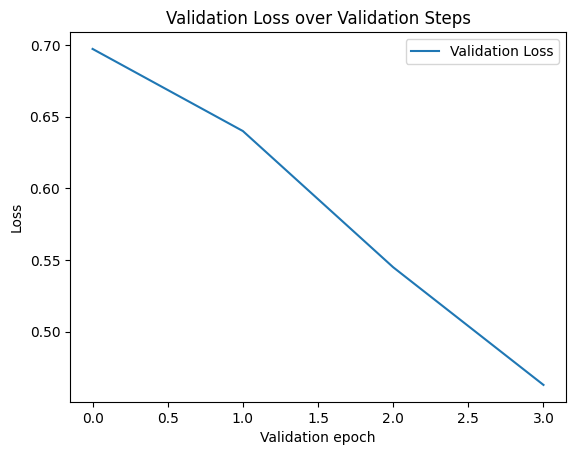

In [147]:
plt.plot(range(len(valid_loss_values)), valid_loss_values, label='Validation Loss')
plt.xlabel('Validation epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Validation Steps')
plt.legend()
plt.show()

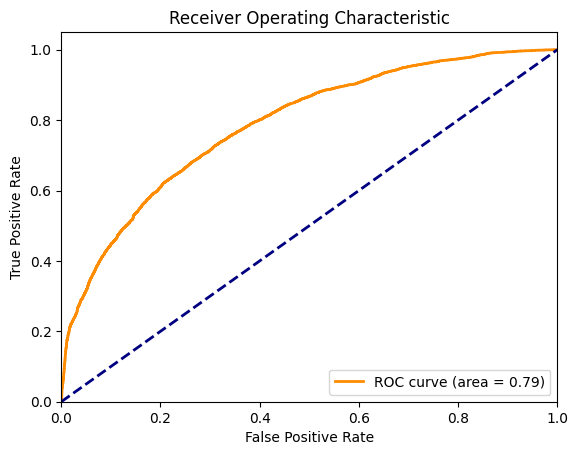

In [148]:
# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(roc_labels, roc_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

test_losses = []

for data, diagnose, labels in valid_dataset_tensor:
    predictions = model([data, diagnose], training=False)
    test_loss = compute_loss(labels, predictions)
    test_losses.append(validation_loss.numpy())

mean_test_loss = np.mean(test_losses)
print("loss: {}".format(mean_test_loss))

loss: 0.3205063045024872


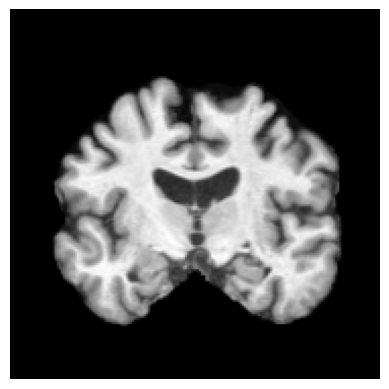

In [ ]:
# 이미지 로드
img_path="/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Mild AD/032_S_4755_121008/plane18.png"
# 이미지를 OpenCV로 읽어온 후, Matplotlib를 사용하여 표시
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 이미지를 Matplotlib로 표시
plt.imshow(image, cmap='gray')
plt.axis('off')  # 축 숨김
plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    def compute_heatmap(self, image, class_index):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.gradient_model(image)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, predictions)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_output = conv_output[0]

        heatmap = conv_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

def overlay_heatmap(image, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
    heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted(heatmap_color, alpha, image, 1 - alpha, 0)
    overlay_img = np.minimum(overlay_img, 255.0).astype(np.uint8)
    return overlay_img

plane_number = 25
subject_number = '002_S_5018_131118'
# 이미지 로드
img_path=f"/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Mild AD/{subject_number}/plane{plane_number}.png"
# image = cv2.imread(img_path)
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.resize(image, (299, 299))
image = np.expand_dims(image, axis=0)

# 모델 및 Grad-CAM 생성
model_CNN = model.pretrained_model.inception_res_partial
# defalut = 'conv_7b'
gradcam = GradCAM(model_CNN, 'conv_7b')

# 클래스 인덱스 선택 (모델이 분류하는 클래스 중 하나)
class_index = 1

# eager execution 활성화
tf.config.experimental_run_functions_eagerly(True)
# 모델을 훈련 모드로 설정
tf.keras.backend.set_learning_phase(1)

# Grad-CAM 히트맵 생성
heatmap = gradcam.compute_heatmap(image, class_index)

# 원본 이미지에 히트맵 오버레이
overlay = overlay_heatmap(image[0], heatmap)




folder_path = f'/content/drive/MyDrive/Dataset/Grad_cam_img_folder/{subject_number}/'
# Check if the directory exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# 결과 표시
plt.matshow(heatmap)
plt.savefig(os.path.join(folder_path, f'heatmap{plane_number}.png'))
plt.show()
cv2_imshow(overlay)
cv2.imwrite(os.path.join(folder_path, f'overlay{plane_number}.png'),overlay)

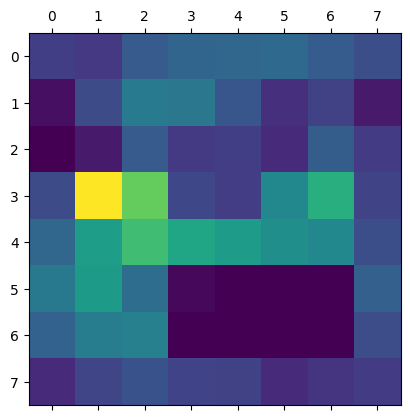

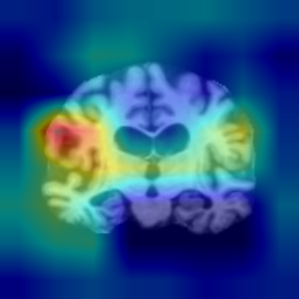

True

In [152]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    def compute_heatmap(self, image, class_index):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.gradient_model(image)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, predictions)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_output = conv_output[0]

        heatmap = conv_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

def overlay_heatmap(image, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
    heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted(heatmap_color, alpha, image, 1 - alpha, 0)
    overlay_img = np.minimum(overlay_img, 255.0).astype(np.uint8)
    return overlay_img

plane_number = 15
subject_number = '005_S_0814_071127'
# 이미지 로드
img_path=f"/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Mild AD/{subject_number}/plane{plane_number}.png"
# image = cv2.imread(img_path)
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.resize(image, (299, 299))
image = np.expand_dims(image, axis=0)

# 모델 및 Grad-CAM 생성
if 'full_model' not in globals():
    full_model =tf.keras.models.load_model('/content/drive/MyDrive/Dataset/before_augmentation_False/inception_resnet')
model_CNN = full_model.pretrained_model.inception_res_partial
gradcam = GradCAM(model_CNN, 'conv_7b')

# 클래스 인덱스 선택 (모델이 분류하는 클래스 중 하나)
class_index = 1

# eager execution 활성화
tf.config.experimental_run_functions_eagerly(True)
# 모델을 훈련 모드로 설정
tf.keras.backend.set_learning_phase(1)

# Grad-CAM 히트맵 생성
heatmap = gradcam.compute_heatmap(image, class_index)

# 원본 이미지에 히트맵 오버레이
overlay = overlay_heatmap(image[0], heatmap)

folder_path = f'/content/drive/MyDrive/Dataset/Grad_cam_img_folder/{subject_number}/'
# Check if the directory exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# 결과 표시
plt.matshow(heatmap)
plt.savefig(os.path.join(folder_path, f'heatmap{plane_number}.png'))
plt.show()
cv2_imshow(overlay)
cv2.imwrite(os.path.join(folder_path, f'overlay{plane_number}.png'), overlay)


In [ ]:
layers_list = model_CNN.layers

# Reverse the list of layers
reversed_layers_list = layers_list[::-1]

# Print the reversed layers list
for layer in reversed_layers_list:
    print(layer.name)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299, 299, 3)), show_shapes=True)

# 이미지 Only 모델

In [ ]:
class Image_Only_model(tf.keras.Model):
    def __init__(self):
        super(Image_Only_model, self).__init__()
        self.inception_res_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
        self.inception_res_partial = models.Model(inputs=self.inception_res_model.input, outputs=self.inception_res_model.output)
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, input):
        x = self.inception_res_partial(input)
        x = self.global_average_pooling(x)
        x = self.dropout(x)
        output = self.output_layer(x)
        return output

In [ ]:
IMAGE_model = Image_Only_model()

In [ ]:
for data, _, labels in train_dataset_tensor.take(1):
    print(data.shape)
    print(labels.shape)


(30, 299, 299, 3)
(30,)


In [ ]:
for data, _, labels in train_dataset_tensor.take(1):
    IMAGE_model(data)



In [ ]:
IMAGE_model.summary()

Model: "image__only_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 model_9 (Functional)        (None, 8, 8, 1536)        54336736  
                                                                 
 global_average_pooling2d_3  multiple                  0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  3074      
                                                                 
Total params: 54339810 (207.29 MB)
Trainable para

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # 1e-3 ->1e-4

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
IMAGE_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
if use_colab:
    checkpoint_dir ='/content/drive/MyDrive/Dataset/Image_Only'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = '/content/drive/MyDrive/Dataset/Image_Only'

In [ ]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)



In [ ]:
def compute_loss(labels, predictions):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

In [ ]:
num_epochs = 5

In [ ]:
# 손실 및 ROC 데이터 저장
train_loss_values = []
valid_loss_values = []
valid_step_values = []  # valid loss와 동일한 인덱스의 valid step 저장
roc_labels = []
roc_predictions = []
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)
print_steps = 10 # tf.gradient_tape
save_epochs = 1 # tf.gradient_tape

# 에폭 반복
prev_validation_loss = float('inf')
for epoch in range(num_epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # 한 에폭당 평균 손실 및 정확도 초기화
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_accuracy = tf.keras.metrics.Accuracy()
    epoch_validation_losses = []
    epoch_validation_labels = []
    epoch_validation_predictions = []

    # 데이터셋 스텝 반복
    for step, (data, _, labels) in enumerate(train_dataset_tensor):
        with tf.GradientTape() as tape:
            predictions = IMAGE_model(data, training=True)
            loss = compute_loss(labels, predictions)

        gradients = tape.gradient(loss, IMAGE_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, IMAGE_model.trainable_variables))

        # 손실 및 정확도 기록
        epoch_train_loss_avg.update_state(loss)
        epoch_train_accuracy.update_state(labels, tf.argmax(predictions, axis=1))

        # 10 스텝마다 손실 값 저장
        if step % 10 == 0:
            train_loss_values.append(epoch_train_loss_avg.result())

        # 각 스텝마다 손실과 정확도 출력
        if step % print_steps == 0:
            print("Step {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(step+1,
                                                                                     epoch_train_loss_avg.result(),
                                                                                     epoch_train_accuracy.result()))

    # validation 데이터셋을 사용하여 모델 평가
    for valid_step,(data, _, labels) in enumerate(valid_dataset_tensor):
        predictions = IMAGE_model(data, training=False)
        validation_loss = compute_loss(labels, predictions)
        epoch_validation_losses.append(validation_loss.numpy())
        epoch_validation_labels.extend(labels.numpy())
        epoch_validation_predictions.extend(tf.argmax(predictions, axis=1).numpy())

        # ROC 커브를 위한 데이터 저장
        roc_labels.extend(labels.numpy())
        roc_predictions.extend(predictions.numpy()[:, 1])  # 1로 예측될 확률만 사용

    # 손실과 정확도 출력
    mean_train_loss = epoch_train_loss_avg.result()
    mean_validation_loss = np.mean(epoch_validation_losses)
    val_accuracy = accuracy_score(epoch_validation_labels, epoch_validation_predictions)
    confusion = confusion_matrix(epoch_validation_labels, epoch_validation_predictions)
    specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
    sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(epoch_validation_labels, epoch_validation_predictions)

    print("Epoch {}: Train Loss {:.3f}, Validation Loss {:.3f}".format(epoch+1, mean_train_loss, mean_validation_loss))
    print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specificity, sensitivity, auc_score))

    # 손실 값 저장
    valid_loss_values.append(mean_validation_loss)
    valid_step_values.append(valid_step)  # 현재 valid step 저장

    # 모델 저장 조건 확인
    if (epoch+1) % save_epochs == 0:
        if mean_validation_loss < prev_validation_loss:
            checkpoint.save(checkpoint_prefix)
            IMAGE_model.save('/content/drive/MyDrive/Dataset/Only_Image_model/inception_resnet', save_format='tf')
            print("Model saved")
            prev_validation_loss = mean_validation_loss


Start of epoch 1
Step 001: Train Loss: 0.781, Train Accuracy: 0.433
Step 011: Train Loss: 0.766, Train Accuracy: 0.506
Step 021: Train Loss: 0.773, Train Accuracy: 0.490
Step 031: Train Loss: 0.760, Train Accuracy: 0.484
Step 041: Train Loss: 0.735, Train Accuracy: 0.522
Step 051: Train Loss: 0.743, Train Accuracy: 0.534
Step 061: Train Loss: 0.730, Train Accuracy: 0.550
Step 071: Train Loss: 0.737, Train Accuracy: 0.539
Step 081: Train Loss: 0.742, Train Accuracy: 0.527
Step 091: Train Loss: 0.754, Train Accuracy: 0.525
Step 101: Train Loss: 0.754, Train Accuracy: 0.526
Step 111: Train Loss: 0.765, Train Accuracy: 0.511
Step 121: Train Loss: 0.759, Train Accuracy: 0.516
Step 131: Train Loss: 0.756, Train Accuracy: 0.514
Step 141: Train Loss: 0.751, Train Accuracy: 0.516
Step 151: Train Loss: 0.751, Train Accuracy: 0.515
Step 161: Train Loss: 0.747, Train Accuracy: 0.520
Step 171: Train Loss: 0.741, Train Accuracy: 0.526
Step 181: Train Loss: 0.748, Train Accuracy: 0.520
Step 191: Tra

KeyboardInterrupt: 